In [1]:
import os
import pickle
import random
import time
import math

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torchvision import datasets, transforms
from torch.autograd import Variable

device = torch.device("cuda")
print("cuda to device done")

import PIL
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from tqdm import tqdm


from torchvision.transforms import ToTensor
from tensorboardX import SummaryWriter
from torch.optim.lr_scheduler import StepLR
from torch.cuda.amp import autocast, GradScaler

#Stage to train (1 or 2)
stage = 2

cuda to device done


# Embedding Compressor

In [5]:
class EmbeddingCompressor(nn.Module):
    def __init__(self):
        super(EmbeddingCompressor, self).__init__()
        self.fc = nn.Linear(1024, 128)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc(x)
        x = self.relu(x)
        return x

# Stage1 Generator

In [3]:
# Define the UpsamplingBlock
class UpSamplingBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpSamplingBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False).to(device)
        x = self.conv(x)
        return x

# Define the Stage 1 Generator
class Stage1Generator(nn.Module):
    def __init__(self):
        super(Stage1Generator, self).__init__()
        #self.ca_network = CANetwork()

        self.fc2 = nn.Sequential(
            nn.Linear(128 + 100, 16384, bias=False),
            nn.ReLU()
        )

        self.upsample_blocks = nn.ModuleList([
            UpSamplingBlock(1024, 512),
            UpSamplingBlock(512, 256),
            UpSamplingBlock(256, 128),
            UpSamplingBlock(128, 64)
        ])

        self.conv_final = nn.Sequential(
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, ca, noise):
        
        x = torch.cat([ca, noise], dim=1).to(device)
        x = self.fc2(x)
        x = x.view(-1, 1024, 4, 4)

        for block in self.upsample_blocks:
            x = block(x)

        x = self.conv_final(x)
        return x

# Stage1 Discriminator

In [6]:
# Define the ConvBlock
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1, activation=True):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.fg_activation = activation
        self.activation = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.conv(x)
        x = self.batch_norm(x)
        if self.fg_activation:
            x = self.activation(x)
        return x
    

# Define the Stage 1 Discriminator
class Stage1Discriminator(nn.Module):
    def __init__(self):
        super(Stage1Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False)
        self.leaky_relu1 = nn.LeakyReLU(0.2)

        self.conv_blocks = nn.ModuleList([
            ConvBlock(64, 128),
            ConvBlock(128, 256),
            ConvBlock(256, 512)
        ])

        self.conv2 = nn.Conv2d(640, 512, kernel_size=1, padding=0, stride=1, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(512)
        self.leaky_relu2 = nn.LeakyReLU(0.2)

        self.flatten = nn.Flatten()
        self.fc = nn.Linear(8192, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, image, mean):
        x1 = self.conv1(image)
        x1 = self.leaky_relu1(x1)
        for block in self.conv_blocks:
            x1 = block(x1)

        concat = torch.cat((x1, mean), dim=1).to(device)
        x2 = self.conv2(concat)
        x2 = self.batch_norm2(x2)
        x2 = self.leaky_relu2(x2)

        x2 = self.flatten(x2)
        x2 = self.fc(x2)
        x2 = self.sigmoid(x2)
        return x2.view(-1)

# Load Dataset

In [8]:
def load_class_ids_filenames(class_id_path, filename_path):
    with open(class_id_path, 'rb') as file:
        class_id = pickle.load(file, encoding='latin1')

    with open(filename_path, 'rb') as file:
        filename = pickle.load(file, encoding='latin1')

    return class_id, filename

def load_text_embeddings(text_embeddings):
    with open(text_embeddings, 'rb') as file:
        embeds = pickle.load(file, encoding='latin1')
        embeds = np.array(embeds)
    return embeds

def load_bbox(data_path):
    bbox_path = os.path.join(data_path, 'bounding_boxes.txt')
    image_path = os.path.join(data_path, 'images.txt')
    bbox_df = pd.read_csv(bbox_path, delim_whitespace=True, header=None).astype(int)
    filename_df = pd.read_csv(image_path, delim_whitespace=True, header=None)

    filenames = filename_df[1].tolist()
    bbox_dict = {i[:-4]: [] for i in filenames[:2]}

    for i in range(0, len(filenames)):
        bbox = bbox_df.iloc[i][1:].tolist()
        dict_key = filenames[i][:-4]
        bbox_dict[dict_key] = bbox

    return bbox_dict

def load_images(image_path, bounding_box, size):
    image = Image.open(image_path).convert('RGB')
    w, h = image.size
    
    if bounding_box is not None:
        r = int(np.maximum(bounding_box[2], bounding_box[3]) * 0.75)
        c_x = int((bounding_box[0] + bounding_box[2]) / 2)
        c_y = int((bounding_box[1] + bounding_box[3]) / 2)
        y1 = np.maximum(0, c_y - r)
        y2 = np.minimum(h, c_y + r)
        x1 = np.maximum(0, c_x - r)
        x2 = np.minimum(w, c_x + r)
        image = image.crop([x1, y1, x2, y2])

    image = image.resize(size, PIL.Image.BILINEAR)
    
    image_transform = transforms.Compose([
            transforms.RandomCrop(size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])
    
    image = image_transform(image)
    
    return image

def load_data(filename_path, class_id_path, dataset_path, embeddings_path, size):
    class_id, filenames = load_class_ids_filenames(class_id_path, filename_path)
    embeddings = load_text_embeddings(embeddings_path)
    bbox_dict = load_bbox(dataset_path)

    x, y, embeds = [], [], []

    with tqdm(total=len(filenames), desc="Loading Data") as pbar:
        for i, filename in enumerate(filenames):
            bbox = bbox_dict[filename]

            try:
                image_path = os.path.join(dataset_path, 'images', f'{filename}.jpg')
                image = load_images(image_path, bbox, size)
                e = embeddings[i, :, :]
                embed_index = np.random.randint(0, e.shape[0] - 1)
                embed = e[embed_index, :]

                x.append(np.array(image))
                y.append(class_id[i])
                embeds.append(embed)

            except Exception as e:
                print(f'{e}')

            # Update the progress bar
            pbar.update(1)

    x = np.array(x)
    y = np.array(y)
    embeds = np.array(embeds)

    return x, y, embeds

def show_img_batch(image_batch, batch_size, fig_size=(64, 64)):
    # Calculate the dimensions of the grid (e.g., 2x2 for 4 images)
    num_rows = int(math.sqrt(batch_size))
    num_cols = int(math.sqrt(batch_size))

    # Create a larger box (figure) to hold the grid of images
    fig, axes = plt.subplots(num_rows, num_cols, figsize=fig_size)

    # Flatten the axes array if it's 2D
    if num_rows == 1 or num_cols == 1:
        axes = axes.reshape(-1)

    # Loop through the images and display them in the grid
    for i, img in enumerate(image_batch):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col]
        
        im = img.data.cpu().numpy()
        im = (im + 1.0) * 127.5
        im = im.astype(np.uint8)

        im = np.transpose(im, (1, 2, 0))

        im = Image.fromarray(im)
        ax.imshow(im)
        ax.axis('off')  # Turn off axis labels and ticks

    # Optionally, adjust spacing between subplots
    plt.subplots_adjust(wspace=0, hspace=0)

    # Show the grid of images
    plt.show()

In [9]:
os.makedirs('/kaggle/working/weights', exist_ok=True)
os.makedirs('/kaggle/working/test', exist_ok=True)
os.makedirs('/kaggle/working/results_stage2', exist_ok=True)

os.makedirs('/kaggle/working/runs', exist_ok=True)

In [10]:
data_dir = "/kaggle/input/birdss/birds"
train_dir = data_dir + "/train"
test_dir = data_dir + "/test"
embeddings_path_train = train_dir + "/char-CNN-RNN-embeddings.pickle"
embeddings_path_test = test_dir + "/char-CNN-RNN-embeddings.pickle"
filename_path_train = train_dir + "/filenames.pickle"
filename_path_test = test_dir + "/filenames.pickle"
class_id_path_train = train_dir + "/class_info.pickle"
class_id_path_test = test_dir + "/class_info.pickle"
dataset_path = "/kaggle/input/cub2002011/CUB_200_2011"

In [11]:
if (stage == 1):
    x_train, y_train, train_embeds = load_data(filename_path=filename_path_train, class_id_path=class_id_path_train,
                                 dataset_path=dataset_path, embeddings_path=embeddings_path_train, size=(64, 64))
    train_dataset = TensorDataset(torch.Tensor(x_train).to(device), torch.Tensor(y_train).to(device), torch.Tensor(train_embeds).to(device))
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)

    x_test, y_test, test_embeds = load_data(filename_path=filename_path_test, class_id_path=class_id_path_test,
                                            dataset_path=dataset_path, embeddings_path=embeddings_path_test, size=(64, 64))

# Stage1 Training

In [13]:
class StackGanStage1(object):
    def __init__(self, epochs=500, z_dim=100, batch_size=64, stage1_generator_lr=0.0002, stage1_discriminator_lr=0.0002):
        self.epochs = epochs
        self.z_dim = z_dim
        self.batch_size = batch_size
        self.image_size = 64
        self.conditioning_dim = 128

        self.embedding_compressor = EmbeddingCompressor().to(device)
        self.stage1_generator = Stage1Generator().to(device)
        self.stage1_discriminator = Stage1Discriminator().to(device)

        self.stage1_generator_optimizer = optim.Adam(self.stage1_generator.parameters(), lr=stage1_generator_lr, betas=(0.5, 0.999))
        self.stage1_discriminator_optimizer = optim.Adam(self.stage1_discriminator.parameters(), lr=stage1_discriminator_lr, betas=(0.5, 0.999))

        self.stage1_generator_optimizer_scheduler = StepLR(self.stage1_generator_optimizer, step_size=20, gamma=0.5)
        self.stage1_discriminator_optimizer_scheduler = StepLR(self.stage1_discriminator_optimizer, step_size=20, gamma=0.5)

        self.real_label = 0.9  # Define the real label value for the loss function
        self.fake_label = 0.1  # Define the fake label value for the loss function

        # Create a summary writer for TensorBoard visualization
        self.writer = SummaryWriter()

    def train_stage1(self):

        for epoch in range(self.epochs):
            gen_loss = []
            dis_loss = []
            num_batches = int(x_train.shape[0] / self.batch_size)

            with tqdm(total=num_batches, desc=f"Training Epoch {epoch + 1}/{self.epochs}") as pbar:
                for batch_idx, (images, labels, embeddings) in enumerate(train_loader):
                    # Train the discriminator
                    self.stage1_discriminator_optimizer.zero_grad()

                    real_images = images.to(device)

                    embeddings = embeddings.to(device)
                    
                    compressed_embedding = self.embedding_compressor(embeddings).to(device)
                    
                    # Generate fake images and conditioning vectors
                    noise = torch.randn(self.batch_size, self.z_dim).to(device)
                    fake_images = self.stage1_generator(compressed_embedding, noise)
                    
                    compressed_embedding = compressed_embedding.view(-1, 128, 1, 1)
                    compressed_embedding = compressed_embedding.repeat(1, 1, 4, 4)

                    # Compute discriminator loss for real and fake images
                    real_labels = (torch.ones(self.batch_size) * 0.9).to(device)
                    fake_labels = (torch.ones(self.batch_size) * 0.1).to(device)
                    
                    real_outputs = self.stage1_discriminator(real_images, compressed_embedding.detach()).to(device)
                    fake_outputs = self.stage1_discriminator(fake_images.detach(), compressed_embedding.detach()).to(device)

                    real_loss = nn.BCELoss()(real_outputs, real_labels)
                    fake_loss = nn.BCELoss()(fake_outputs, fake_labels)
                    discriminator_loss = real_loss + fake_loss

                    discriminator_loss.backward(retain_graph=True)
                    self.stage1_discriminator_optimizer.step()

                    # Train the generator
                    self.stage1_generator_optimizer.zero_grad()
                    
                    fake_outputs = self.stage1_discriminator(fake_images, compressed_embedding).to(device)

                    generator_loss = nn.BCELoss()(fake_outputs, real_labels)

                    generator_loss.backward(retain_graph=True)
                    self.stage1_generator_optimizer.step()

                    gen_loss.append(generator_loss.item())
                    dis_loss.append(discriminator_loss.item())

                    # Update the progress bar
                    pbar.update(1)
                print(f"Epoch {epoch + 1}: Discriminator Loss: {np.mean(dis_loss)}, Generator Loss: {np.mean(gen_loss)}")

            self.stage1_generator_optimizer_scheduler.step()
            self.stage1_discriminator_optimizer_scheduler.step()

            # Print and log losses
            avg_gen_loss = np.mean(gen_loss)
            avg_dis_loss = np.mean(dis_loss)

            self.writer.add_scalar('Generator Loss', avg_gen_loss, epoch)
            self.writer.add_scalar('Discriminator Loss', avg_dis_loss, epoch)

            # Save generated images
            if (epoch + 1) % 5 == 0:
                with torch.no_grad():
                    latent_space = torch.randn(self.batch_size, self.z_dim).to(device)
                    embedding_batch = test_embeds[0 : self.batch_size]
                    compressed_embedding_batch = self.embedding_compressor(torch.tensor(embedding_batch, dtype=torch.float32).to(device)).to(device)
                    gen_images = self.stage1_generator(compressed_embedding_batch, latent_space)
                    
                    show_img_batch(gen_images, 64, (64, 64))

            if (epoch + 1) % 5 == 0:
                torch.save(self.stage1_generator.state_dict(), f'/kaggle/working/weights/stage1_gen_{epoch + 1}.pth')
                torch.save(self.stage1_discriminator.state_dict(), f'/kaggle/working/weights/stage1_disc_{epoch + 1}.pth')
                torch.save(self.embedding_compressor.state_dict(), f'/kaggle/working/weights/stage1_embco_{epoch + 1}.pth')

In [10]:
if (stage == 1):
    #stage1 = StackGanStage1(epochs=150)
    stage1 = StackGanStage1()
    stage1.train_stage1()

# Stage2 Generator

In [14]:
class ConcatAlongDims(nn.Module):
    def forward(self, inputs):
        c, x = inputs
        c = c.unsqueeze(2).unsqueeze(3).repeat(1, 1, 16, 16)
        return torch.cat([c, x], dim=1)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, input):
        x = self.conv1(input)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x += input
        x = self.relu(x)
        return x

class Stage2Generator(nn.Module):
    def __init__(self):
        super(Stage2Generator, self).__init__()
        self.conditioning_augmentation = nn.Sequential(
            nn.Linear(1024, 256),
            nn.LeakyReLU(0.2)
        )
        
        self.concat_along_dims = ConcatAlongDims()
        
        self.downsampling_block = nn.Sequential(
            nn.ZeroPad2d(1),
            nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=0, bias=False),
            nn.ReLU(),
            nn.ZeroPad2d(1),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ZeroPad2d(1),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.residual_blocks = nn.Sequential(
            nn.ZeroPad2d(1),
            nn.Conv2d(640, 512, kernel_size=3, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            ResidualBlock(512, 512),
            ResidualBlock(512, 512),
            ResidualBlock(512, 512),
            ResidualBlock(512, 512)
        )

        self.upsampling_blocks = nn.ModuleList([
            UpSamplingBlock(512, 256),
            UpSamplingBlock(256, 128),
            UpSamplingBlock(128, 64)
        ])

        self.final_conv = nn.Conv2d(64, 3, kernel_size=3, padding=1, bias=False)
        self.tanh = nn.Tanh()

    def forward(self, input_layer1, input_images):
        
        x = self.downsampling_block(input_images)
        concat = self.concat_along_dims((input_layer1, x))

        x = self.residual_blocks(concat)

        for upsample_block in self.upsampling_blocks:
            x = upsample_block(x)

        x = self.final_conv(x)
        x = self.tanh(x)
        return x

# Stage2 Discriminator

In [15]:
class Stage2Discriminator(nn.Module):
    def __init__(self):
        super(Stage2Discriminator, self).__init__()

        self.conv1 = nn.Conv2d(3, 128, kernel_size=4, stride=2, padding=1, bias=False)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.conv_blocks = nn.Sequential(
            ConvBlock(128, 256),
            ConvBlock(256, 512),
            ConvBlock(512, 1024),
            ConvBlock(1024, 512, kernel_size=1, stride=1, padding=0),
            ConvBlock(512, 256, kernel_size=1, stride=1, padding=0, activation=False),
        )

        self.conv_block_x1 = nn.Sequential(
            ConvBlock(256, 64, kernel_size=1, stride=1, padding=0),
            ConvBlock(64, 64, kernel_size=3, stride=1),
            ConvBlock(64, 256, kernel_size=3, stride=1, activation=False),
        )

        self.conv2 = nn.Conv2d(384, 512, kernel_size=1, stride=1, padding=0, bias=False)
        self.batchnorm = nn.BatchNorm2d(512)
        
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32768, 1),
            nn.Sigmoid(),
        )

    def forward(self, input_layer1, mean):
        x1 = self.conv1(input_layer1)
        x1 = self.leaky_relu(x1)
        x1 = self.conv_blocks(x1)
        
        x = self.conv_block_x1(x1)
        
        x2 = x + x1
        x2 = self.leaky_relu(x2)
        
        concat = torch.cat((x2, mean), dim=1)

        x3 = self.conv2(concat)
        x3 = self.batchnorm(x3)
        x3 = self.leaky_relu(x3)
        x3 = self.fc(x3)
        return x3.view(-1)

#  Load Dataset

In [16]:
if (stage == 2):
    x_high_train, y_high_train, high_train_embeds = load_data(filename_path=filename_path_train, class_id_path=class_id_path_train,
        dataset_path=dataset_path, embeddings_path=embeddings_path_train, size=(128, 128))
    train_high_dataset = TensorDataset(torch.Tensor(x_high_train), torch.Tensor(y_high_train), torch.Tensor(high_train_embeds))
    train_high_loader = DataLoader(train_high_dataset, batch_size=64, shuffle=True, drop_last=True)

    x_high_test, y_high_test, high_test_embeds = load_data(filename_path=filename_path_test, class_id_path=class_id_path_test,
        dataset_path=dataset_path, embeddings_path=embeddings_path_test, size=(128, 128))

Loading Data: 100%|██████████| 2933/2933 [00:38<00:00, 76.82it/s]


# Stage2 Training

In [17]:
class StackGanStage2(object):
    def __init__(self, epochs=500, z_dim=100, batch_size=64, enable_function=True, stage2_generator_lr=0.0002, stage2_discriminator_lr=0.0002):
        self.epochs = epochs
        self.z_dim = z_dim
        self.enable_function = enable_function
        
        self.low_image_size = 64
        self.high_image_size = 128
        self.conditioning_dim = 128
        self.batch_size = batch_size
        
        self.stage1_generator = generator.to(device)
        self.stage2_generator = stage2_gen.to(device)
        self.embedding_compressor = embedding_compressor.to(device)
        self.stage2_discriminator = stage2_dis.to(device)
        self.stage2_generator_optimizer = torch.optim.Adam(self.stage2_generator.parameters(), lr=stage2_generator_lr, betas=(0.5, 0.999))
        self.stage2_discriminator_optimizer = torch.optim.Adam(self.stage2_discriminator.parameters(), lr=stage2_discriminator_lr, betas=(0.5, 0.999))
        
        self.stage2_generator_optimizer_scheduler = StepLR(self.stage2_generator_optimizer, step_size=20, gamma=0.5)
        self.stage2_discriminator_optimizer_scheduler = StepLR(self.stage2_discriminator_optimizer, step_size=20, gamma=0.5)
        
        # Create a summary writer for TensorBoard visualization
        self.writer = SummaryWriter()

    def train_stage2(self):
        
        for epoch in range(self.epochs):
            
            torch.cuda.empty_cache()
            
            gen_loss = []
            dis_loss = []
            num_batches = int(x_high_train.shape[0] / self.batch_size)
            
            with tqdm(total=num_batches, desc=f"Training Epoch {epoch + 1}/{self.epochs}") as pbar:
                for batch_idx, (images, labels, embeddings) in enumerate(train_high_loader):
                    self.stage2_discriminator_optimizer.zero_grad()
                    
                    embeddings = embeddings.to(device)
                    
                    latent_space = torch.randn(self.batch_size, self.z_dim).to(device)

                    real_images = images.to(device)
                    
                    compressed_embedding = self.embedding_compressor(embeddings).to(device)

                    # Generate images
                    low_res_fakes = self.stage1_generator(compressed_embedding.detach(), latent_space)
                    high_res_fakes = self.stage2_generator(compressed_embedding.detach(), low_res_fakes.detach().to(device))
                    high_res_fakes = high_res_fakes.to(device)
                    
                    compressed_embedding = compressed_embedding.view(-1, 128, 1, 1)
                    compressed_embedding = compressed_embedding.repeat(1, 1, 8, 8)

                    # Train discriminator
                    real = (torch.ones(self.batch_size) * 0.9).to(device)
                    fake = (torch.ones(self.batch_size) * 0.1).to(device)
                    
                    real_output = self.stage2_discriminator(real_images, compressed_embedding.detach()).to(device)
                    real_loss = nn.BCELoss()(real_output, real)
                    fake_output = self.stage2_discriminator(high_res_fakes.detach(), compressed_embedding.detach()).to(device)
                    fake_loss = nn.BCELoss()(fake_output, fake)
                    d_loss = real_loss + fake_loss
                    
                    d_loss.backward(retain_graph=True)
                    self.stage2_discriminator_optimizer.step()
                    dis_loss.append(d_loss.item())

                    # Train generator
                    self.stage2_generator_optimizer.zero_grad()
    
                    fake_outputs = self.stage2_discriminator(high_res_fakes, compressed_embedding.detach()).to(device)
                    generator_loss = nn.BCELoss()(fake_outputs, real)
                    g_loss = generator_loss
                    
                    g_loss.backward(retain_graph=True)
                    self.stage2_generator_optimizer.step()
                    gen_loss.append(g_loss.item())
                    
                    # Update the progress bar
                    pbar.update(1)
                    
            print(f"Epoch {epoch + 1}: Discriminator Loss: {np.mean(dis_loss)}, Generator Loss: {np.mean(gen_loss)}")
                    
            self.stage2_generator_optimizer_scheduler.step()
            self.stage2_discriminator_optimizer_scheduler.step()
                
            avg_gen_loss = np.mean(gen_loss)
            avg_dis_loss = np.mean(dis_loss)
            self.writer.add_scalar('Generator Loss', avg_gen_loss, epoch)
            self.writer.add_scalar('Discriminator Loss', avg_dis_loss, epoch)

            # Save generated images
            if (epoch + 1) % 25 == 0:
                with torch.no_grad():
                    latent_space = torch.randn(self.batch_size, self.z_dim).to(device)
                    embedding_batch = high_test_embeds[0 : self.batch_size]
                    embedding_tensor = torch.tensor(embedding_batch, dtype=torch.float32).to(device)
                    embedding_batch_compressed = self.embedding_compressor(embedding_tensor).to(device)
                    low_fake_images = self.stage1_generator(embedding_batch_compressed, latent_space)
                    high_fake_images = self.stage2_generator(embedding_batch_compressed, low_fake_images)

                    show_img_batch(low_fake_images, 64, (64, 64))
                    show_img_batch(high_fake_images, 64, (128, 128))

            # Save weights
            if (epoch + 1) % 5 == 0:
                torch.save(self.stage2_generator.state_dict(), f'/kaggle/working/results_stage2/stage2_gen_{epoch + 1}.pth')
                torch.save(self.stage2_discriminator.state_dict(), f'/kaggle/working/results_stage2/stage2_disc_{epoch + 1}.pth')

In [ ]:
if (stage == 2):
    #define the path of the generator weights of stage 1
    path_gen1 = '/kaggle/input/weightsss/stage1_gen_150.pth'
    #define the path of the embedding compressor weights of stage 1
    path_emb1 = '/kaggle/input/weightsss/stage1_embco_150.pth'
    
    generator = Stage1Generator()
    checkpoint1 = torch.load(path_gen1, map_location=device)
    generator.load_state_dict(checkpoint1)

    embedding_compressor = EmbeddingCompressor()
    checkpoint2 = torch.load(path_emb1, map_location=device)
    embedding_compressor.load_state_dict(checkpoint2)

    stage2_gen = Stage2Generator()
    stage2_dis = Stage2Discriminator()

    stackgan_stage2 = StackGanStage2(epochs=150)
    stackgan_stage2.train_stage2()

# Print of results

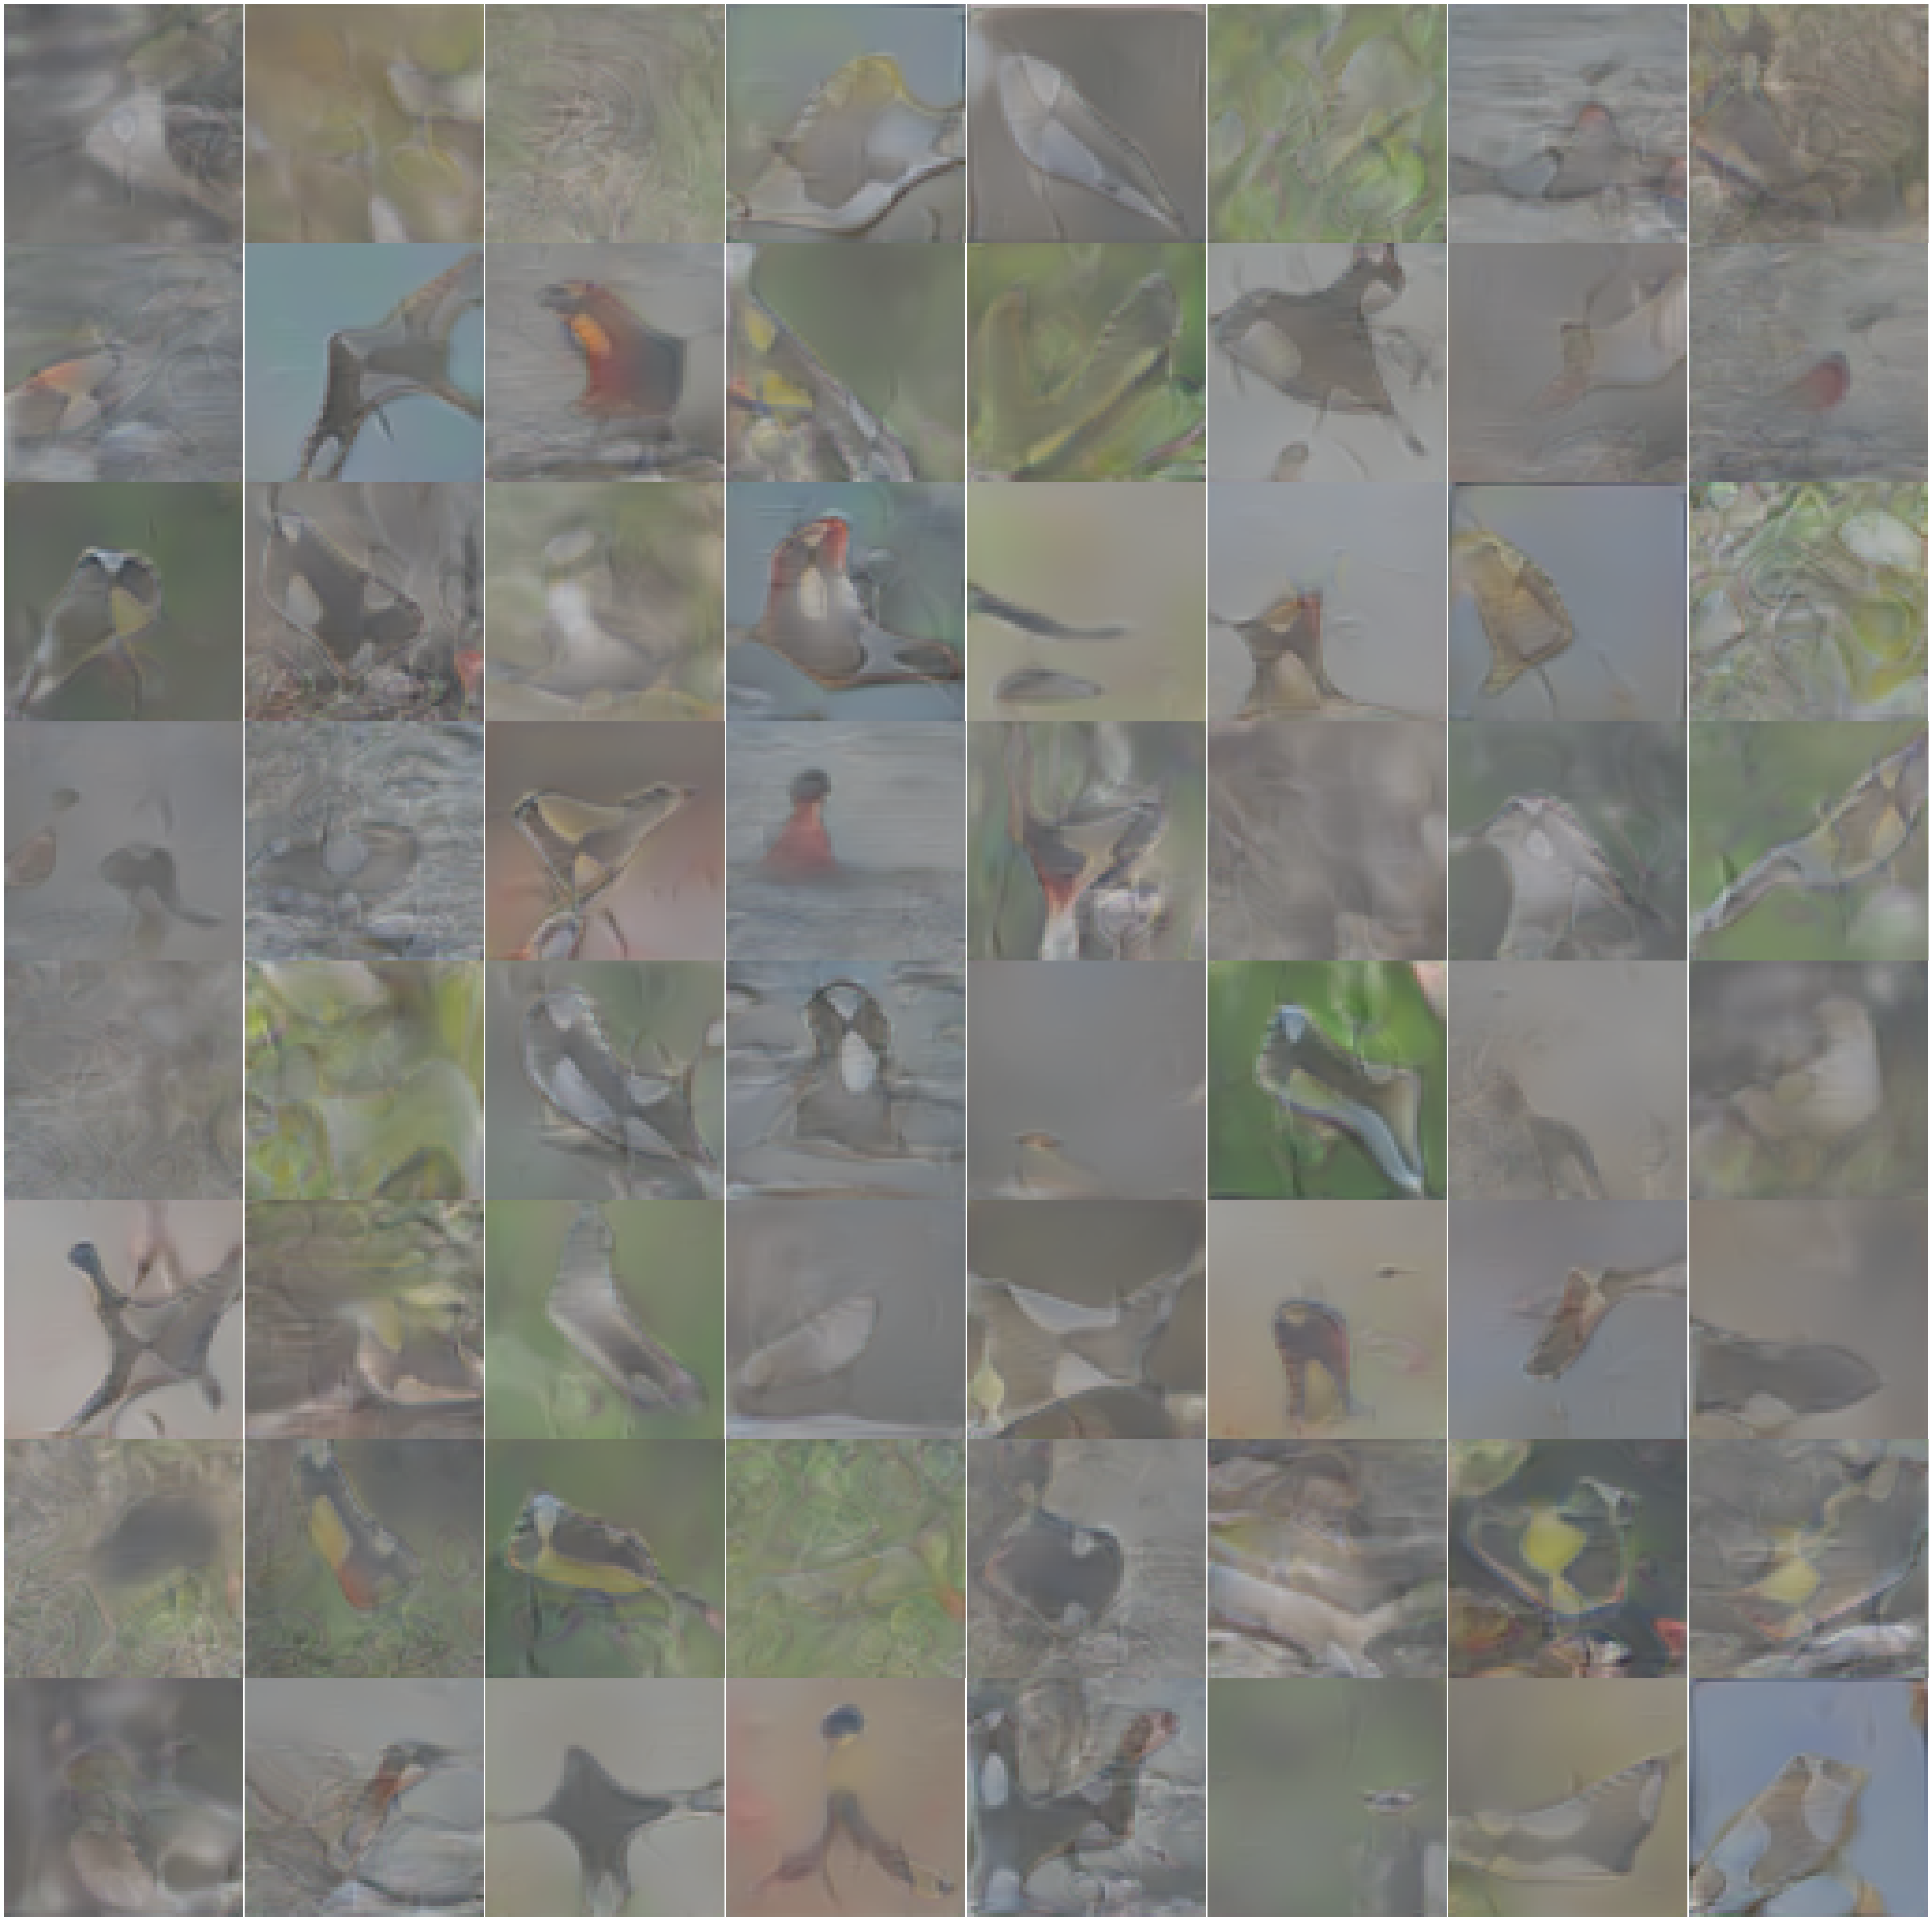

In [24]:
stage1_generator = Stage1Generator().to(device)
embedding_compressor = EmbeddingCompressor().to(device)
stage2_generator = Stage2Generator().to(device).to(device)

checkpoint1 = torch.load('/kaggle/input/weightsss/stage1_gen_150.pth', map_location=device)
checkpoint2 = torch.load('/kaggle/input/weightsss/stage1_embco_150.pth', map_location=device)
checkpoint3 = torch.load('/kaggle/input/weightsss/stage2_gen_150.pth', map_location=device)

stage1_generator.load_state_dict(checkpoint1)
stage2_generator.load_state_dict(checkpoint3)
embedding_compressor.load_state_dict(checkpoint2)

latent_space = torch.randn(64, 100).to(device)
embedding_batch = high_test_embeds[0 : 64]
compressed_embedding_batch = embedding_compressor(torch.tensor(embedding_batch, dtype=torch.float32).to(device)).to(device)
gen_images = stage1_generator(compressed_embedding_batch, latent_space)
high_fake_images = stage2_generator(compressed_embedding_batch, gen_images)


show_img_batch(gen_images, 64, (64, 64))
show_img_batch(high_fake_images, 64, (128, 128))


In [ ]:
from IPython.display import FileLink
!zip -r file.zip /kaggle/working
FileLink(r'file.zip')